In [73]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
warnings.filterwarnings("ignore")

def Preprocessing_and_handling_None():

    global data ,testing

    train = pd.read_csv('/kaggle/input/playground-series-s3e22/train.csv')
    testing = pd.read_csv('/kaggle/input/playground-series-s3e22/test.csv')                     
    data = pd.concat([train ,testing] ,ignore_index= True)

    del data['id'],data['hospital_number']

    data = pd.get_dummies(data ,columns=['surgery','age','cp_data','surgical_lesion'] ,drop_first=True ,dtype=np.int32)

    data['temp_of_extremities'].replace({'warm':1,'normal':2,'None':np.nan,'cool':3,'cold':4},inplace=True)
    data["temp_of_extremities"] = data["temp_of_extremities"].fillna(data.groupby("pulse")["temp_of_extremities"].transform("median"))
    data["temp_of_extremities"] = data["temp_of_extremities"].astype('int')

    data['peripheral_pulse'].replace({'reduced':1,'normal':2,'None':np.nan,'increased':3,'absent':4},inplace=True)
    data["peripheral_pulse"] = data["peripheral_pulse"].fillna(data.groupby("temp_of_extremities")["peripheral_pulse"].transform('median'))

    data['mucous_membrane'].replace({'normal_pink':1,'bright_pink':2,'None':np.nan,'pale_pink':3,'pale_cyanotic':4,'bright_red':5,'dark_cyanotic':6},inplace=True)
    data["mucous_membrane"] = data["mucous_membrane"].fillna(data.groupby("temp_of_extremities")["mucous_membrane"].transform('median'))

    data['capillary_refill_time'].replace({'less_3_sec':1,'more_3_sec':2,'None':np.nan,'cool':3, 3:4},inplace=True)
    data['capillary_refill_time'] = data['capillary_refill_time'].astype('float')
    data["capillary_refill_time"] = data["capillary_refill_time"].fillna(data.groupby("packed_cell_volume")["capillary_refill_time"].transform('median'))

    data = data[data['pain'] != 'slight']
    data['pain'].replace({'alert':1,'depressed':2,'None':np.nan,'mild_pain':3,'severe_pain':4,'extreme_pain':5,'dark_cyanotic':6 ,'moderate':np.nan},inplace=True)
    data["pain"] = data["pain"].fillna(data.groupby("surgery_yes")["pain"].transform('median'))
    data = pd.get_dummies(data ,columns=['pain'] ,dtype=np.int32)

    data = data[data['peristalsis'] != 'distend_small']
    data['peristalsis'].replace({'absent':1,'hypomotile':2,'None':np.nan,'normal':3,'hypermotile':4,'bright_red':5,},inplace=True)
    data["peristalsis"] = data["peristalsis"].fillna(data.groupby(["surgery_yes","temp_of_extremities"])["peristalsis"].transform('median'))

    data['abdominal_distention'].replace({'none':1,'slight':2,'None':np.nan,'moderate':3,'severe':4},inplace=True)
    data["abdominal_distention"] = data["abdominal_distention"].fillna(data.groupby(["surgery_yes","temp_of_extremities"])["abdominal_distention"].transform('median'))

    data['nasogastric_tube'].replace({'none':1,'slight':2,'None':np.nan,'significant':3},inplace=True)
    data["nasogastric_tube"] = data["nasogastric_tube"].fillna(data.groupby(["packed_cell_volume",'respiratory_rate'])["nasogastric_tube"].transform('median'))
    data["nasogastric_tube"].fillna(data['nasogastric_tube'].mean() ,inplace=True)
    data["nasogastric_tube"] = data["nasogastric_tube"].astype('int')

    data['nasogastric_reflux'].replace({'none':1,'slight':1,'None':np.nan,'less_1_liter':2 ,'more_1_liter':3},inplace=True)
    data["nasogastric_reflux"] = data["nasogastric_reflux"].fillna(data.groupby(["total_protein"])["nasogastric_reflux"].transform('median'))
    data["nasogastric_reflux"] = data["nasogastric_reflux"].astype('int')

    data['rectal_exam_feces'].replace({'decreased':1,'normal':2,'None':np.nan,'serosanguious':np.nan,'increased':3 ,'absent':4},inplace=True)
    data["rectal_exam_feces"] = data["rectal_exam_feces"].fillna(data.groupby(["abdominal_distention"])["rectal_exam_feces"].transform('median'))

    data['abdomen'].replace({'normal':1,'firm':2,'None':np.nan,'distend_small':3,'distend_large':4 ,'other':5},inplace=True)
    data["abdomen"] = data["abdomen"].fillna(data.groupby(["abdominal_distention",'peristalsis','rectal_exam_feces','surgery_yes'])["abdomen"].transform('median'))
    data["abdomen"].fillna(data['abdomen'].median() ,inplace=True)
    data["abdomen"] = data["abdomen"].astype('int')

    data['abdomo_appearance'].replace({'clear':1,'cloudy':2,'None':np.nan,'serosanguious':3 },inplace=True)
    data["abdomo_appearance"] = data["abdomo_appearance"].fillna(data.groupby(["temp_of_extremities",'pulse'])["abdomo_appearance"].transform('median'))
    data["abdomo_appearance"] = data["abdomo_appearance"].astype('int')
    data['outcome'].replace({'lived':1,'died':0,'euthanized':2},inplace=True)


Preprocessing_and_handling_None()

# Correlation

<Axes: >

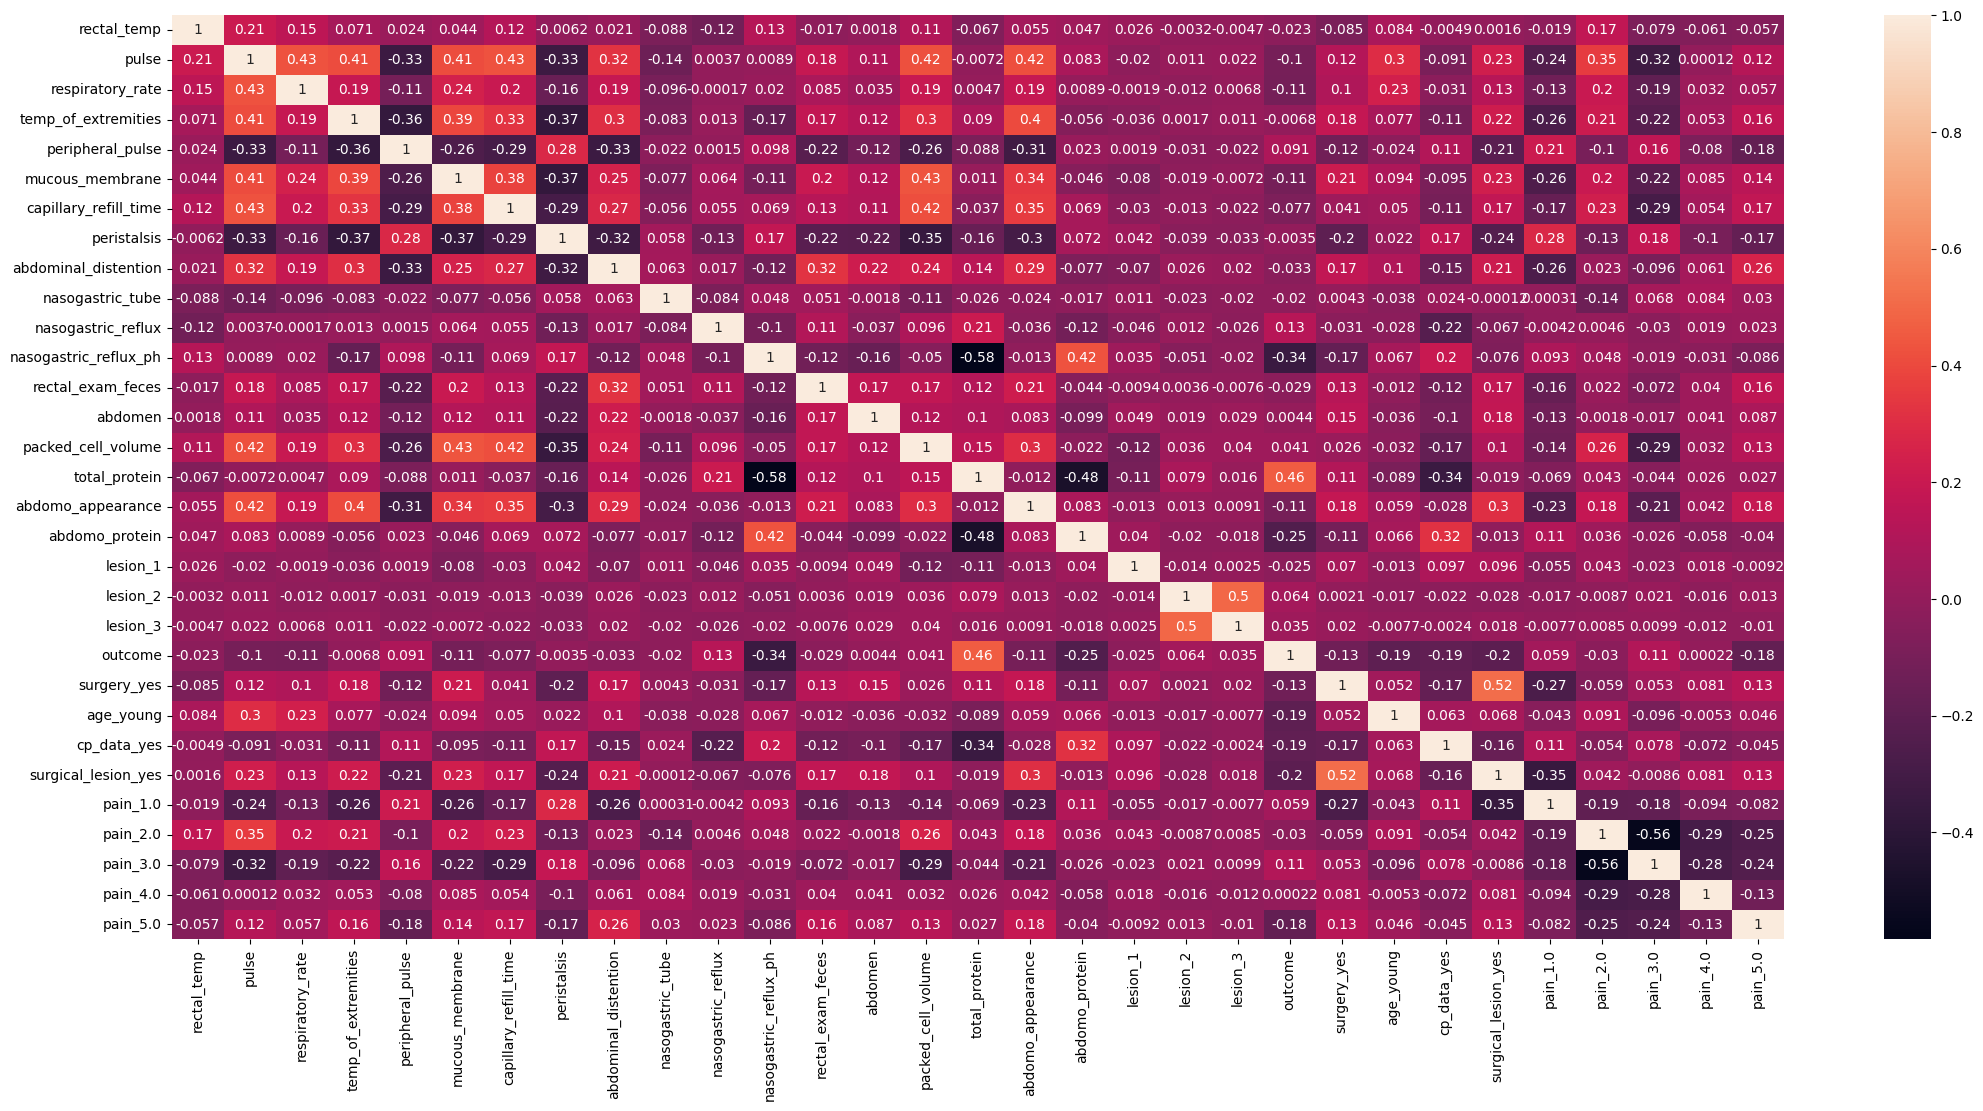

In [74]:
plt.figure(figsize=(26,12))
sns.heatmap(data.corr(),annot=True)

# Outliers

In [75]:
def Outliers():
    
    global train ,TEST
    
    train = data[data['outcome'].notnull()]

    TEST = data[data['outcome'].isnull()]
    del TEST['outcome']


    flt1 = (train['rectal_temp'] <= 40) & (train['rectal_temp'] > 36.2)
    train = train[flt1]

    flt2 = (train['pulse'] < 146)
    train = train[flt2]

    flt3 = (train['lesion_1'] < 9_000)
    train = train[flt3]

    flt4 = ((train['abdomo_protein'] <= 9) & (train['abdomo_protein'] >= 1 ))
    train = train[flt4]
    
    
Outliers()

# Modeling

In [76]:
Normalize = MinMaxScaler()

X = train.drop('outcome' ,axis=1)
y = train['outcome']

X = Normalize.fit_transform(X)
TEST = Normalize.transform(TEST)

x_train , x_test , y_train , y_test = train_test_split(X , y , test_size=0.17 , random_state=42)


model = GradientBoostingClassifier(n_estimators=40, learning_rate=0.3, max_depth=1)     
model.fit(x_train, y_train)

predictions = model.predict(TEST)

model.fit(x_train, y_train)
model.score(x_test ,y_test)

0.75

# Submission

In [77]:
df = pd.DataFrame(testing['id'])

df['outcome'] = predictions
df.replace({1:"lived" ,0:'died' ,2:'euthanized'} ,inplace=True)
# df.to_csv('GradientBoosting.csv' ,index=False)